In [24]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchaudio.transforms import Resample

import timm
from timm.models.layers import to_2tuple, trunc_normal_

import numpy as np
import pandas as pd
import pickle

import os
import wget
import glob
import time
import datetime

import matplotlib.pyplot as plt

In [7]:
if os.path.exists('audioset_10_10_0.4593.pth') == False:
    audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
    wget.download(audioset_mdl_url, out='audioset_10_10_0.4593.pth')

In [8]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024):

        super(ASTModel, self).__init__()
        
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=True)

        self.original_num_patches = self.v.patch_embed.num_patches
        self.oringal_hw = int(self.original_num_patches ** 0.5)
        self.original_embedding_dim = self.v.pos_embed.shape[2]
        self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

        # automatcially get the intermediate shape
        f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
        num_patches = f_dim * t_dim
        self.v.patch_embed.num_patches = num_patches

        # the linear projection layer
        new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
        new_proj.bias = self.v.patch_embed.proj.bias
        self.v.patch_embed.proj = new_proj

        # the positional embedding
        # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
        new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
        # cut (from middle) or interpolate the second dimension of the positional embedding
        if t_dim <= self.oringal_hw:
            new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
        else:
            new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
        # cut (from middle) or interpolate the first dimension of the positional embedding
        if f_dim <= self.oringal_hw:
            new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
        else:
            new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
        # flatten the positional embedding
        new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
        # concatenate the above positional embedding with the cls token and distillation token of the deit model.
        self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

/home/penguin/anaconda3/envs/PT/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
class VehicleCountingDataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.audio_files = glob.glob(os.path.join(self.dataset_path, "*.wav"))
        self.vc_files = glob.glob(os.path.join(self.dataset_path, "*.txt"))

    def __len__(self):
        return len(self.audio_files)


In [27]:
DATASET_PATH = "../VC-PRG-1_5/"
TARGET_SAMPLE_RATE = 16000
MEL_BINS = 128
TARGET_LENGTH = 1024

audio_files = glob.glob(os.path.join(DATASET_PATH, "*.wav"))
vc_files = glob.glob(os.path.join(DATASET_PATH, "*.txt"))

def _get_signal(item):
    signal, sample_rate = torchaudio.load(audio_files[item])
    return signal, sample_rate

def _get_vc(item):
    vc = 0
    with open(vc_files[item], "r") as f:
        vc = len(f.readlines())
    return vc

def _resample_if_necessary(signal, sample_rate):
    if sample_rate != TARGET_SAMPLE_RATE:
        resampler = Resample(sample_rate, TARGET_SAMPLE_RATE)
        signal = resampler(signal)
    return signal

def _extract_fbank(signal):
    fbank = torchaudio.compliance.kaldi.fbank(signal, htk_compat=True, sample_frequency=TARGET_SAMPLE_RATE, use_energy=False, window_type="hanning", num_mel_bins=MEL_BINS, dither=0.0, frame_shift=10)
    return fbank

def _cut_if_necessary(fbank):
    if (TARGET_LENGTH - fbank.shape[0]) < 0:
        fbank = fbank[:TARGET_LENGTH, :]
    return fbank

def _pad_if_necessary(fbank):
    if (TARGET_LENGTH - fbank.shape[0]) > 0:
        padder = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = padder(fbank)
    return fbank

def __getitem__(item):
    label = _get_vc(item)
    signal, sample_rate = _get_signal(item)
    signal = _resample_if_necessary(signal, sample_rate)
    fbank = _extract_fbank(signal)
    fbank = _cut_if_necessary(fbank)
    fbank = _pad_if_necessary(fbank)

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    feats_data = fbank.expand(1, TARGET_LENGTH, MEL_BINS)
    return feats_data, label

torch.Size([1, 1024, 128])
4


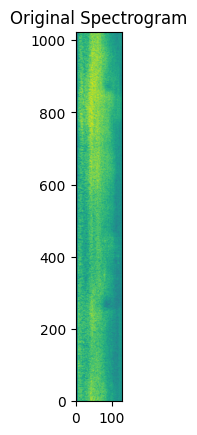

In [30]:
feats_data, label = __getitem__(26)
print(feats_data.shape)
print(label)

plt.imshow(feats_data[0], origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()